# In-Class Exercise on Spam Filtering  
In this exercise, we will use powerful tools such as pandas and sklearn to distinguish between spam and regular emails based on the information contained in the emails themselves.


In [1]:
%pip install gdown pandas numpy seaborn matplotlib scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import gdown
import zipfile
import os
import re
import pandas as pd  
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, classification_report
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer, HashingVectorizer
from sklearn.preprocessing import MinMaxScaler


In [3]:
# import sys
# import os
# import platform

# # Python environment details
# print("Python executable being used:", sys.executable)
# print("Python version:", sys.version)

# # Operating System details
# print("Operating System:", platform.system())
# print("OS Version:", platform.version())
# print("OS Release:", platform.release())

# # Machine and architecture details
# print("Machine:", platform.machine())

# # Visual Studio Code details (based on environment variable)
# vscode_info = os.environ.get('VSCODE_PID', None)
# if vscode_info:
#     print("Running in Visual Studio Code")
# else:
#     print("Not running in Visual Studio Code")

Python executable being used: e:\anaconda3\envs\ml_env_test\python.exe
Python version: 3.12.8 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:48:34) [MSC v.1929 64 bit (AMD64)]
Operating System: Windows
OS Version: 10.0.19045
OS Release: 10
Machine: AMD64
Running in Visual Studio Code


## Download Data  
The data is downloaded using gdown into the same folder as the current file. After downloading, we unzip the received data.

In [47]:
#### YOUR CODE HERE ####
# Data link: https://drive.google.com/uc?id=1bTJKchSInd3IgLs41b1_-Gd-T36a_pal

url = "https://drive.google.com/uc?id=1bTJKchSInd3IgLs41b1_-Gd-T36a_pal"
output_zip = "downloaded_data.zip"

# Download
gdown.download(url, output_zip, quiet=False)

# Unzip 
with zipfile.ZipFile(output_zip, "r") as zip_ref:
    zip_ref.extractall(os.getcwd()) 

#### END YOUR CODE #####

Downloading...
From: https://drive.google.com/uc?id=1bTJKchSInd3IgLs41b1_-Gd-T36a_pal
To: e:\2_LEARNING_BKU\2_File_2\K22_HK242\CO3085_NLP\BT\Lab04\InClass\downloaded_data.zip
100%|██████████| 1.95M/1.95M [00:00<00:00, 6.60MB/s]


## Using Pandas for Storage  
Pandas is a commonly used library for storing data utilized in machine learning processes, offering functions suitable for large datasets and high performance. We read the data from the unzipped file into a `DataFrame`.


In [5]:
#### YOUR CODE HERE ####
ds = pd.DataFrame(pd.read_csv("spam_ham_dataset.csv"))
#### END YOUR CODE #####

Visualizing Data with 5 Examples 

In [6]:
#### YOUR CODE HERE ####
ds.head(5)
#### END YOUR CODE #####

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


## Data Preprocessing  
As we can see, the current data contains Windows newline characters `\r\n`, which may cause confusion. To simplify, we replace them with spaces. You can also apply additional Pandas methods (e.g., removing the "Subject:" prefix, extracting the first line, etc.).


In [ ]:
#### YOUR CODE HERE ####

# Data Cleaning
ds["text"] = ds["text"].astype(str)                                 # Ensure text is string
ds["text"] = ds["text"].str.replace("\r\n", " ", regex=True)        # Replace Windows newlines with space
ds["text"] = ds["text"].str.replace("^Subject: ", "", regex=True)   # Remove 'Subject:' prefix
ds["text"] = ds["text"].apply(lambda x: x.split(".")[0])            # Extract and use only the first sentence

#### END YOUR CODE #####

## Building Model  
First, we perform vectorization of the input data using `CountVectorizer`, aiming to convert text data into numerical representations. `CountVectorizer` creates a vocabulary of words appearing in the dataset and generates a corresponding vector for each sample, representing the word frequencies within that sample.


In [8]:
#### YOUR CODE HERE ####

# Vectorization
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(ds["text"])  

print("Shape of vectorized data:", X.shape) # format (# samples, # unique words)
print("Sample features:", vectorizer.get_feature_names_out()[:10]) 

#### END YOUR CODE #####

Shape of vectorized data: (5171, 14841)
Sample features: ['00' '000' '0000' '0001' '0004' '001' '002' '0027' '0030' '0033']


Next, we apply the TF-IDF algorithm to the obtained vector. The output remains a sparse matrix but is now adjusted for the rarity of each word.


In [9]:
#### YOUR CODE HERE ####

# Apply TF-IDF transformation to the CountVectorizer output
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X)  # Convert count-based representation to TF-IDF

print("Shape of TF-IDF transformed data:", X_tfidf.shape)
print("Sample TF-IDF values:", X_tfidf[0].toarray()[:, :10]) 

#### END YOUR CODE #####

Shape of TF-IDF transformed data: (5171, 14841)
Sample TF-IDF values: [[0.16044789 0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]]


We can generate n-gram data using the `ngram_range` argument in `CountVectorizer`, allowing the program to capture commonly occurring n-word phrases in the dataset.  

Additionally, `CountVectorizer` and `TfidfTransformer` have a combined wrapper that integrates both processes into one while accepting their shared arguments: `TfidfVectorizer`.

Equivalent to `CountVectorizer` followed by `TfidfTransformer`

In [10]:
#### YOUR CODE HERE ####

# Apply TfidfVectorizer with n-gram range (e.g., bigrams and trigrams)
vectorizer = TfidfVectorizer(ngram_range=(1, 3))        # Capture unigrams, bigrams, and trigrams
X_tfidf_ngram = vectorizer.fit_transform(ds["text"])    # Transform text data into TF-IDF representation

print("Shape of TF-IDF n-gram transformed data:", X_tfidf_ngram.shape)
print("Sample n-gram features:", vectorizer.get_feature_names_out()[:10])  

#### END YOUR CODE #####

Shape of TF-IDF n-gram transformed data: (5171, 137611)
Sample n-gram features: ['00' '00 00' '00 00 pm' '00 000' '00 000 mmbtu' '00 01' '00 01 and'
 '00 02' '00 02 06' '00 02 29']


After completing the vectorization steps, we proceed to split the data into training and testing sets to evaluate the model's performance

In [11]:
#### YOUR CODE HERE ####

X_train, X_test, y_train, y_test = train_test_split(X_tfidf_ngram, ds["label_num"], test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

#### END YOUR CODE #####

Shape of X_train: (4136, 137611)
Shape of X_test: (1035, 137611)
Shape of y_train: (4136,)
Shape of y_test: (1035,)


In [12]:
# print("First 5 rows of X_train (dense format):")
# print(X_train[:5].toarray())

# print("First 5 labels of y_train:", y_train[:5])

# print("First 5 rows of X_test (dense format):")
# print(X_test[:5].toarray())

# print("First 5 labels of y_test:", y_test[:5])


First 5 rows of X_train (dense format):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
First 5 labels of y_train: 5132    0
2067    1
4716    0
4710    0
2268    1
Name: label_num, dtype: int64
First 5 rows of X_test (dense format):
[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.05441699 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
First 5 labels of y_test: 1566    0
1988    1
1235    0
2868    0
4903    0
Name: label_num, dtype: int64


Once we have the vectorized data, we use a Bayesian model to compute the results, such as `GaussianNB`. Other machine learning models can also be applied here (e.g., `LogisticRegression`, `SVM`).  

**Note:** The `todense()` function is used to convert a sparse matrix to a dense matrix, which may cause `MemoryError` for large datasets. Consider using models that support training with sparse matrices or implementing your own solution here.


In [13]:
#### YOUR CODE HERE ####

# List of models to evaluate
models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=2000, solver="saga"),
    "SVM": SVC(kernel='linear', probability=True, max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100)
}

# Initialize dictionaries to store metrics and reports
model_reports = {}
roc_auc_scores = {}

target_names = ds['label'].unique()

# Loop through models to train and evaluate them
for model_name, model in models.items():
    print(f"Training {model_name}...")

    # Convert to dense for models that don't support sparse input
    if model_name == "GaussianNB":
        X_train_dense = X_train.toarray()  # Convert to dense for GaussianNB
        X_test_dense = X_test.toarray()    # Convert test data to dense as well
        model.fit(X_train_dense, y_train)
        X_data_train, X_data_test = X_train_dense, X_test_dense  # Assign dense data for prediction
    else:
        model.fit(X_train, y_train)  # Use sparse data for other models
        X_data_train, X_data_test = X_train, X_test  # Use sparse data for prediction

    # Predict on test set
    y_pred = model.predict(X_data_test)

    # Classification Report with target_names (store in the dictionary)
    class_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    model_reports[model_name] = class_report

    # Store ROC-AUC score for ROC curve plotting
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_data_test)[:, 1]  # Get probabilities for AUC calculation
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        roc_auc_scores[model_name] = roc_auc
    else:
        # Handle models that don't support predict_proba (like SVM)
        y_pred_prob = model.decision_function(X_data_test)  # Use decision function for SVM
        roc_auc = roc_auc_score(y_test, y_pred_prob)
        roc_auc_scores[model_name] = roc_auc

#### END YOUR CODE #####

Training GaussianNB...
Training MultinomialNB...
Training LogisticRegression...
Training SVM...


e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training RandomForest...


## Metrics and Visualization  
To evaluate the model's performance, we can compute the F1 score or accuracy. In this case, we use the F1 score since the class distribution in the dataset is imbalanced (with 25% spam).  

Additionally, we can plot the ROC-AUC curve to visualize different cutoff points for the model.


In [14]:
#### YOUR CODE HERE ####

for model_name in models.keys():
    print(f"Classification Report for {model_name}:\n{model_reports[model_name]}")
    print(f"ROC-AUC Score for {model_name}: {roc_auc_scores[model_name]:.2f}\n")

#### END YOUR CODE #####

Classification Report for GaussianNB:
{'ham': {'precision': 0.9691275167785235, 'recall': 0.9730458221024259, 'f1-score': 0.9710827168796234, 'support': 742.0}, 'spam': {'precision': 0.9310344827586207, 'recall': 0.9215017064846417, 'f1-score': 0.9262435677530018, 'support': 293.0}, 'accuracy': 0.9584541062801932, 'macro avg': {'precision': 0.9500809997685721, 'recall': 0.9472737642935338, 'f1-score': 0.9486631423163125, 'support': 1035.0}, 'weighted avg': {'precision': 0.9583436916888312, 'recall': 0.9584541062801932, 'f1-score': 0.9583891220060967, 'support': 1035.0}}
ROC-AUC Score for GaussianNB: 0.95

Classification Report for MultinomialNB:
{'ham': {'precision': 0.8073993471164309, 'recall': 1.0, 'f1-score': 0.893437688139675, 'support': 742.0}, 'spam': {'precision': 1.0, 'recall': 0.39590443686006827, 'f1-score': 0.5672371638141809, 'support': 293.0}, 'accuracy': 0.8289855072463768, 'macro avg': {'precision': 0.9036996735582155, 'recall': 0.6979522184300342, 'f1-score': 0.7303374

In [44]:
for model_name in models.keys():
    print("="*50)
    print(f"Model: {model_name}")
    print("="*50)
    
    report = model_reports[model_name]
    for label, metrics in report.items():
        if isinstance(metrics, dict):  # Filter out the 'accuracy' part
            print(f"{label: <20}: Precision: {metrics['precision']:.3f}, Recall: {metrics['recall']:.3f}, F1-score: {metrics['f1-score']:.3f}")
        else:
            print(f"{label: <20}: {metrics}")
    
    # Print ROC-AUC score
    print(f"{'ROC-AUC Score': <20}: {roc_auc_scores[model_name]:.3f}")
    

Model: GaussianNB
ham                 : Precision: 0.969, Recall: 0.973, F1-score: 0.971
spam                : Precision: 0.931, Recall: 0.922, F1-score: 0.926
accuracy            : 0.9584541062801932
macro avg           : Precision: 0.950, Recall: 0.947, F1-score: 0.949
weighted avg        : Precision: 0.958, Recall: 0.958, F1-score: 0.958
ROC-AUC Score       : 0.947
Model: MultinomialNB
ham                 : Precision: 0.807, Recall: 1.000, F1-score: 0.893
spam                : Precision: 1.000, Recall: 0.396, F1-score: 0.567
accuracy            : 0.8289855072463768
macro avg           : Precision: 0.904, Recall: 0.698, F1-score: 0.730
weighted avg        : Precision: 0.862, Recall: 0.829, F1-score: 0.801
ROC-AUC Score       : 0.993
Model: LogisticRegression
ham                 : Precision: 0.849, Recall: 0.996, F1-score: 0.917
spam                : Precision: 0.982, Recall: 0.553, F1-score: 0.707
accuracy            : 0.8705314009661835
macro avg           : Precision: 0.916, Recall

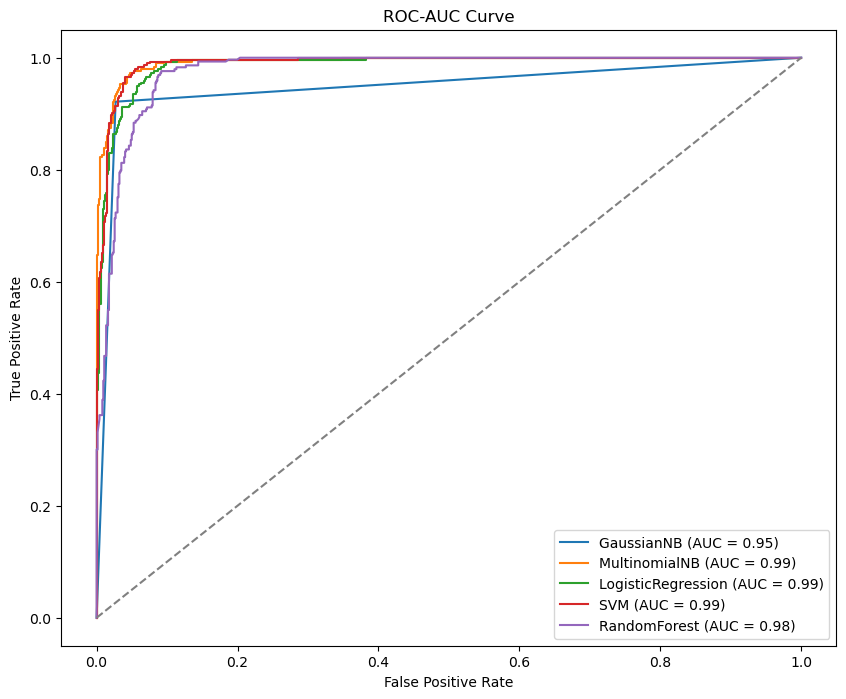

ROC-AUC Scores: {'GaussianNB': 0.9472737642935337, 'MultinomialNB': 0.9926772950148569, 'LogisticRegression': 0.9871576681416335, 'SVM': 0.9905660377358491, 'RandomForest': 0.9771372455222027}


In [16]:
plt.figure(figsize=(10, 8))
for model_name, model in models.items():
    y_pred_prob = model.predict_proba(X_test_dense)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_scores[model_name]:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

print("ROC-AUC Scores:", roc_auc_scores)


## Alternative: Co-occurrence and TruncatedSVD  

In language, semantically related words (e.g., *doctor* and *patient*) often appear in the same context. Based on this idea, we can construct a co-occurrence matrix that captures word occurrences within sentences. This allows us to represent words in a shared vector space rather than relying on simple frequency counts.  

A co-occurrence matrix with a window spanning the entire sentence can be built using the existing `CountVectorizer` data or manually constructed.


In [17]:
#### YOUR CODE HERE ####

corpus = ds['text']

vectorizer = CountVectorizer(ngram_range=(1, 1))  # Unigrams
X = vectorizer.fit_transform(corpus)  # Sparse representation

co_occurrence_matrix = (X.T @ X).toarray()  # Efficient sparse multiplication
alpha = 0  # Smoothing factor - Em tinh dung ma nghi chac la khong can smoothing
smoothed_matrix = co_occurrence_matrix + alpha  # Adds smoothing to all elements

words = vectorizer.get_feature_names_out()

co_occurrence_df = pd.DataFrame(co_occurrence_matrix, index=words, columns=words)

print("Shape of Co-Occurrence Matrix:", co_occurrence_df.shape)
print("Co-Occurrence Matrix with Labels:\n", co_occurrence_df)

#### END YOUR CODE #####

Shape of Co-Occurrence Matrix: (14841, 14841)
Co-Occurrence Matrix with Labels:
                 00  000  0000  0001  0004  001  002  0027  0030  0033  ...  \
00            1879   97     0     0     4    0    0     0     0     0  ...   
000             97  758     0     0     0    0    3     0     0     0  ...   
0000             0    0     1     0     0    0    0     0     0     0  ...   
0001             0    0     0     1     0    0    0     0     0     0  ...   
0004             4    0     0     0     7    0    0     0     0     0  ...   
...            ...  ...   ...   ...   ...  ...  ...   ...   ...   ...  ...   
zusammenhang     0    0     0     0     0    0    0     0     0     0  ...   
zustande         0    0     0     0     0    0    0     0     0     0  ...   
zv               0    0     0     0     0    0    0     0     0     0  ...   
zwallet          0    0     0     0     0    0    0     0     0     0  ...   
zyban            0    0     0     0     0    0    0     0    

In [ ]:
# Step 4: Apply TruncatedSVD for Dimensionality Reduction
n_components = 100  
svd = TruncatedSVD(n_components=n_components)
reduced_matrix = svd.fit_transform(smoothed_matrix)  # Apply SVD

# Step 5: Convert to DataFrame
words = vectorizer.get_feature_names_out()
reduced_df = pd.DataFrame(reduced_matrix, index=words)  # Each word as a row in reduced space

# Step 6: Extract the Top 20 Most Important Words
word_importance = np.linalg.norm(reduced_matrix, axis=1)  # Compute importance (L2 norm)
top_20_words = [words[i] for i in np.argsort(word_importance)[-20:]]  # Get top 20 words

# Step 7: Create a Co-Occurrence Matrix for Top 20 Words in Reduced Space
top_20_reduced_df = reduced_df.loc[top_20_words, :]
top_20_co_occurrence = np.dot(top_20_reduced_df, top_20_reduced_df.T)
top_20_co_occurrence_df = pd.DataFrame(top_20_co_occurrence, index=top_20_words, columns=top_20_words)


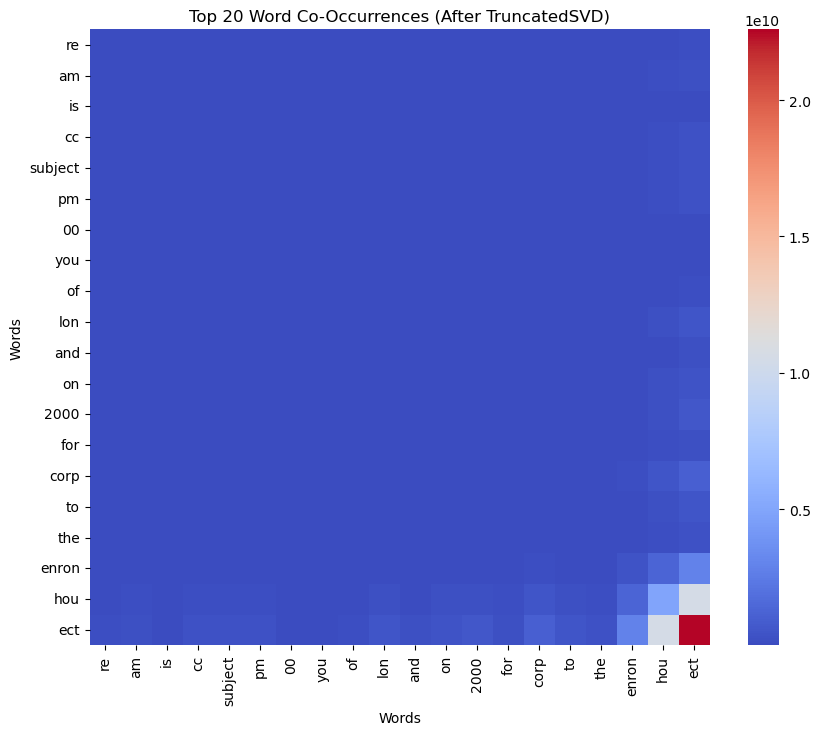

In [19]:
# Step 8: Visualize the Co-Occurrence Matrix of Top 20 Words (Without Values)
plt.figure(figsize=(10, 8))
sns.heatmap(top_20_co_occurrence_df, cmap="coolwarm", annot=False, xticklabels=top_20_words, yticklabels=top_20_words)
plt.title("Top 20 Word Co-Occurrences (After TruncatedSVD)")
plt.xlabel("Words")
plt.ylabel("Words")
plt.show()


In [20]:
# Step 9: Print Important Information
print(f"Original Co-Occurrence Matrix Shape: {co_occurrence_matrix.shape}")
print(f"Reduced Matrix Shape after TruncatedSVD: {reduced_matrix.shape}")
print("\nTop 20 Most Important Words (Based on SVD):")
print(top_20_words)

Original Co-Occurrence Matrix Shape: (14841, 14841)
Reduced Matrix Shape after TruncatedSVD: (14841, 100)

Top 20 Most Important Words (Based on SVD):
['re', 'am', 'is', 'cc', 'subject', 'pm', '00', 'you', 'of', 'lon', 'and', 'on', '2000', 'for', 'corp', 'to', 'the', 'enron', 'hou', 'ect']


In [21]:
print(reduced_matrix.shape)
reduced_matrix

(14841, 100)


array([[ 2.13508062e+02,  1.39743480e+03,  5.89048410e+01, ...,
        -6.15272086e+00, -4.00676108e+00,  7.37552711e+00],
       [ 1.69407215e+02,  9.76401486e+02,  4.20050214e+00, ...,
         1.78500033e+01,  1.88629501e+01,  1.20283681e+00],
       [ 1.87675284e+01,  3.37320940e+00,  2.88040846e+00, ...,
        -4.61703394e-01, -9.75749316e-01, -1.49397114e+00],
       ...,
       [ 4.96121017e-02,  1.56102658e+00, -5.83876833e-01, ...,
         1.10712738e-01,  1.98995122e-01,  4.24134838e-03],
       [ 1.20660041e-03,  5.70954680e-02, -3.98497497e-02, ...,
         1.68362307e-02, -2.49697082e-02, -2.78099708e-02],
       [ 1.77954565e-01,  5.79049347e+00, -2.04028338e+00, ...,
        -1.06171326e-01,  1.14292251e+00, -7.43317060e-01]])

In [22]:
ds.head(10)

,Unnamed: 0,label,text,label_num
0,605,ham,enron methanol ; meter # : 988291 this is a fo...,0
1,2349,ham,"hpl nom for january 9 , 2001 ( see attached fi...",0
2,3624,ham,"neon retreat ho ho ho , we ' re around to that...",0
3,4685,spam,"photoshop , windows , office",1
4,2030,ham,re : indian springs this deal is to book the t...,0
5,2949,ham,ehronline web address change this message is i...,0
6,2793,ham,spring savings certificate - take 30 % off sav...,0
7,4185,spam,looking for medication ? we ` re the best source,1
8,2641,ham,noms / actual flow for 2 / 26 we agree - - - -...,0
9,1870,ham,nominations for oct,0


In [23]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [ ]:
texts = ds["text"].tolist()  # Extract texts
labels = ds["label_num"].values  # Extract labels

In [26]:
print(smoothed_matrix.shape)
print(reduced_matrix.shape)

(14841, 14841)
(14841, 100)


In [ ]:
word_to_vec = {word: reduced_matrix[i] for i, word in enumerate(words)}

In [29]:
def compute_document_vector(doc, word_to_vec, embedding_dim=100):
    words = doc.split()
    word_vectors = [word_to_vec[word] for word in words if word in word_to_vec]
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)  # Average word embeddings
    else:
        return np.zeros(embedding_dim)  # Handle empty docs


In [30]:
document_vectors = np.array([compute_document_vector(doc, word_to_vec) for doc in texts])  

X_train_co, X_test_co, y_train_co, y_test_co = train_test_split(document_vectors, labels, test_size=0.2, random_state=42)
print("Shape of X_train:", X_train_co.shape)
print("Shape of X_test:", X_test_co.shape)
print("Shape of y_train:", y_train_co.shape)
print("Shape of y_test:", y_test_co.shape)

Shape of X_train: (4136, 100)
Shape of X_test: (1035, 100)
Shape of y_train: (4136,)
Shape of y_test: (1035,)


Need to to do this because the transformed SVD feauture contain negative values, which the Multinomial does not designed for

In [ ]:
scaler = MinMaxScaler()

X_train_co_scaled = scaler.fit_transform(X_train_co)
X_test_co_scaled = scaler.transform(X_test_co)

In [32]:
# List of models to evaluate
models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=2000, solver="saga"),
    "SVM": SVC(kernel='linear', probability=True, max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100)
}

# Initialize dictionaries to store metrics and reports
model_reports_co = {}
roc_auc_scores_co = {}
target_names = ds['label'].unique()

# Train and evaluate models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    if model_name == "MultinomialNB":
        model.fit(X_train_co_scaled, y_train_co)
        y_pred = model.predict(X_test_co_scaled)
    else:
        model.fit(X_train_co, y_train_co)
        y_pred = model.predict(X_test_co)
    
    class_report = classification_report(y_test_co, y_pred, target_names=target_names, output_dict=True, zero_division=1)
    model_reports_co[model_name] = class_report
    
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_test_co)[:, 1]
    else:
        y_pred_prob = model.decision_function(X_test_co)
    
    roc_auc = roc_auc_score(y_test_co, y_pred_prob)
    roc_auc_scores_co[model_name] = roc_auc


Training GaussianNB...
Training MultinomialNB...
Training LogisticRegression...


e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Training SVM...


e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training RandomForest...


In [45]:
# Beautified Output
for model_name in models.keys():
    print("="*50)
    print(f"Model: {model_name}")
    print("="*50)
    
    report = model_reports_co[model_name]
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"{label: <20}: Precision: {metrics['precision']:.3f}, Recall: {metrics['recall']:.3f}, F1-score: {metrics['f1-score']:.3f}")
        else:
            print(f"{label: <20}: {metrics}")
    
    print(f"{'ROC-AUC Score': <20}: {roc_auc_scores_co[model_name]:.3f}")


Model: GaussianNB
ham                 : Precision: 0.925, Recall: 0.713, F1-score: 0.805
spam                : Precision: 0.540, Recall: 0.853, F1-score: 0.661
accuracy            : 0.7526570048309179
macro avg           : Precision: 0.732, Recall: 0.783, F1-score: 0.733
weighted avg        : Precision: 0.816, Recall: 0.753, F1-score: 0.764
ROC-AUC Score       : 0.861
Model: MultinomialNB
ham                 : Precision: 0.717, Recall: 1.000, F1-score: 0.835
spam                : Precision: 1.000, Recall: 0.000, F1-score: 0.000
accuracy            : 0.7169082125603865
macro avg           : Precision: 0.858, Recall: 0.500, F1-score: 0.418
weighted avg        : Precision: 0.797, Recall: 0.717, F1-score: 0.599
ROC-AUC Score       : 0.735
Model: LogisticRegression
ham                 : Precision: 0.849, Recall: 0.953, F1-score: 0.898
spam                : Precision: 0.827, Recall: 0.570, F1-score: 0.675
accuracy            : 0.8444444444444444
macro avg           : Precision: 0.838, Recall

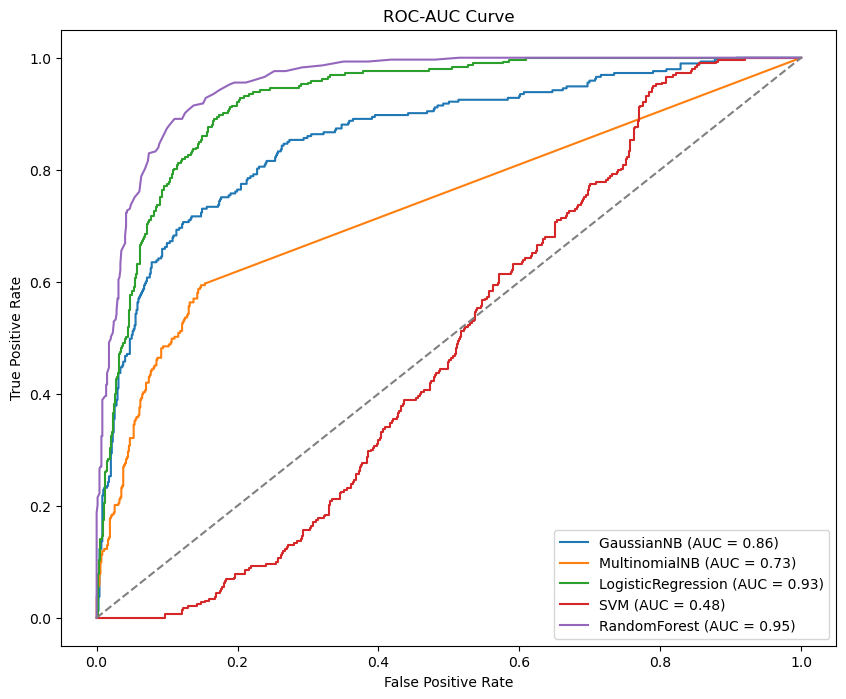

ROC-AUC Scores: {'GaussianNB': 0.8612825772977747, 'MultinomialNB': 0.7349613166149969, 'LogisticRegression': 0.925337847161532, 'SVM': 0.4835561116068554, 'RandomForest': 0.9544239809388886}


In [35]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    y_pred_prob = model.predict_proba(X_test_co)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_co, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_scores_co[model_name]:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

print("ROC-AUC Scores:", roc_auc_scores_co)

## Alternative: HashingVectorizer  

For large datasets with a high vocabulary size, using `CountVectorizer` for vectorized data storage can be resource-intensive. An alternative approach is to use `HashingVectorizer`. Unlike `CountVectorizer`, which assigns a unique ID to each word/ngram, `HashingVectorizer` maps multiple words to the same ID using a hashing function.  

The choice between these two methods involves a trade-off between memory usage (e.g., RAM) and model quality. Adjusting the `n_features` parameter helps balance this trade-off to ensure that model performance does not degrade significantly.


In [36]:
#### YOUR CODE HERE ####

# Apply HashingVectorizer with n-grams
vectorizer_hashed = HashingVectorizer(n_features=2**16, ngram_range=(1, 3), alternate_sign=False)
X_hashed = vectorizer_hashed.fit_transform(ds["text"])  # Transform text data

# Display shape of transformed data
print("Shape of Hashed n-gram transformed data:", X_hashed.shape)

# Split dataset
X_hashed_train, X_hashed_test, y_hashed_train, y_hashed_test = train_test_split(X_hashed, ds["label_num"], test_size=0.2, random_state=42)

print("Shape of X_train:", X_hashed_train.shape)
print("Shape of X_test:", X_hashed_test.shape)
print("Shape of y_train:", y_hashed_train.shape)
print("Shape of y_test:", y_hashed_test.shape)

#### END YOUR CODE #####

Shape of Hashed n-gram transformed data: (5171, 65536)
Shape of X_train: (4136, 65536)
Shape of X_test: (1035, 65536)
Shape of y_train: (4136,)
Shape of y_test: (1035,)


## Comparison and Analysis of Feature Extraction Methods  

### Now just train the model for the use of HashingVectorizer for vectorization first

In [37]:
# List of models to evaluate
models = {
    "GaussianNB": GaussianNB(),
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=2000, solver="saga"),
    "SVM": SVC(kernel='linear', probability=True, max_iter=1000),
    "RandomForest": RandomForestClassifier(n_estimators=100)
}

# Initialize dictionaries to store metrics and reports
model_reports_hashed = {}
roc_auc_scores_hashed = {}
target_names = ds['label'].unique()

# Train and evaluate models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    
    if model_name == "GaussianNB":
        X_hashed_train_dense = X_hashed_train.toarray()
        X_hashed_test_dense = X_hashed_test.toarray()
        model.fit(X_hashed_train_dense, y_hashed_train)
        X_hashed_data_test = X_hashed_test_dense
    else:
        model.fit(X_hashed_train, y_hashed_train)
        X_hashed_data_test = X_hashed_test
    
    y_pred = model.predict(X_hashed_data_test)
    class_report = classification_report(y_hashed_test, y_pred, target_names=target_names, output_dict=True)
    model_reports_hashed[model_name] = class_report
    
    if hasattr(model, "predict_proba"):
        y_pred_prob = model.predict_proba(X_hashed_data_test)[:, 1]
    else:
        y_pred_prob = model.decision_function(X_hashed_data_test)
    
    roc_auc = roc_auc_score(y_hashed_test, y_pred_prob)
    roc_auc_scores_hashed[model_name] = roc_auc


Training GaussianNB...
Training MultinomialNB...
Training LogisticRegression...
Training SVM...


e:\anaconda3\envs\ml_env_test\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Training RandomForest...


In [46]:
# Beautified Output
for model_name in models.keys():
    print("="*50)
    print(f"Model: {model_name}")
    print("="*50)
    
    report = model_reports_hashed[model_name]
    for label, metrics in report.items():
        if isinstance(metrics, dict):
            print(f"{label: <20}: Precision: {metrics['precision']:.3f}, Recall: {metrics['recall']:.3f}, F1-score: {metrics['f1-score']:.3f}")
        else:
            print(f"{label: <20}: {metrics}")
    print(f"{'ROC-AUC Score': <20}: {roc_auc_scores_hashed[model_name]:.3f}")


Model: GaussianNB
ham                 : Precision: 0.824, Recall: 0.977, F1-score: 0.894
spam                : Precision: 0.890, Recall: 0.471, F1-score: 0.616
accuracy            : 0.8338164251207729
macro avg           : Precision: 0.857, Recall: 0.724, F1-score: 0.755
weighted avg        : Precision: 0.843, Recall: 0.834, F1-score: 0.815
ROC-AUC Score       : 0.724
Model: MultinomialNB
ham                 : Precision: 0.801, Recall: 1.000, F1-score: 0.890
spam                : Precision: 1.000, Recall: 0.372, F1-score: 0.542
accuracy            : 0.8222222222222222
macro avg           : Precision: 0.901, Recall: 0.686, F1-score: 0.716
weighted avg        : Precision: 0.858, Recall: 0.822, F1-score: 0.791
ROC-AUC Score       : 0.988
Model: LogisticRegression
ham                 : Precision: 0.912, Recall: 0.966, F1-score: 0.938
spam                : Precision: 0.900, Recall: 0.765, F1-score: 0.827
accuracy            : 0.9091787439613527
macro avg           : Precision: 0.906, Recall

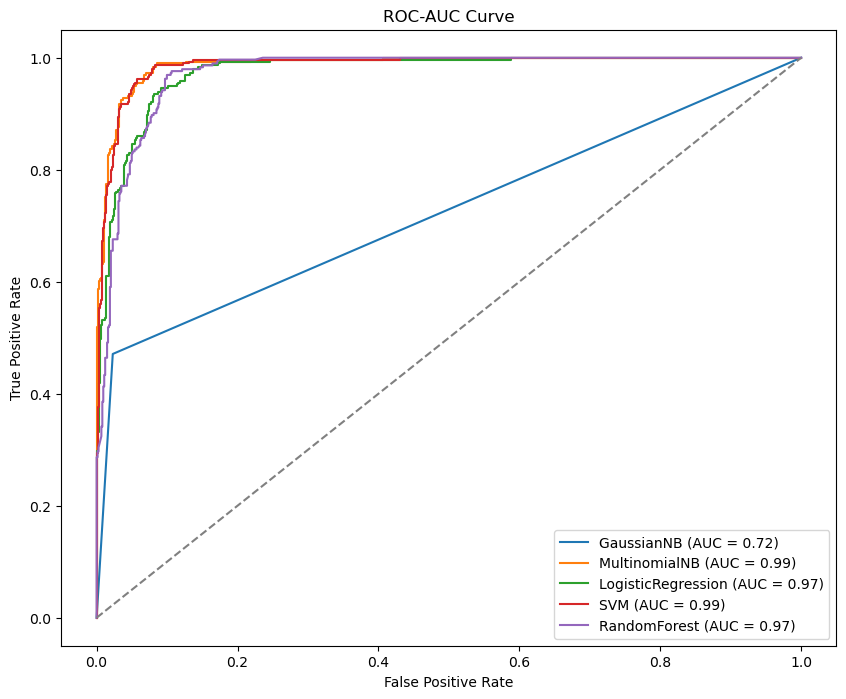

ROC-AUC Scores: {'GaussianNB': 0.724039354939606, 'MultinomialNB': 0.9876406354930407, 'LogisticRegression': 0.9748534999034064, 'SVM': 0.9863849203793823, 'RandomForest': 0.9730182239680598}


In [39]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))

for model_name, model in models.items():
    y_pred_prob = model.predict_proba(X_hashed_test_dense)[:, 1]
    fpr, tpr, _ = roc_curve(y_hashed_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc_scores_hashed[model_name]:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.title('ROC-AUC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

print("ROC-AUC Scores:", roc_auc_scores_hashed)

### Now compare between the use of TfidfVectorizer, Cooccurence Matrix + TruncatedSVD and HashingVectorizer for giving the better performance for all models

In [40]:
# Create a DataFrame to store the comparison of ROC-AUC scores for different vectorizers
comparison_df = pd.DataFrame({
    "Model": models.keys(),
    "ROC-AUC (TF-IDF)": [roc_auc_scores[model] for model in models.keys()],
    "ROC-AUC (Co-TruncatedSVD)": [roc_auc_scores_co[model] for model in models.keys()],
    "ROC-AUC (Hashing)": [roc_auc_scores_hashed[model] for model in models.keys()]
})

# Determine the best vectorizer for each model by selecting the one with the highest ROC-AUC
comparison_df["Best Vectorizer"] = comparison_df[
    ["ROC-AUC (TF-IDF)", "ROC-AUC (Co-TruncatedSVD)", "ROC-AUC (Hashing)"]
].idxmax(axis=1).str.replace("ROC-AUC ", "").str.replace("(", "").str.replace(")", "")

# Find the best model and vectorizer overall based on the highest ROC-AUC score
best_model_tfidf = comparison_df.loc[comparison_df["ROC-AUC (TF-IDF)"].idxmax(), "Model"]
best_score_tfidf = comparison_df["ROC-AUC (TF-IDF)"].max()

best_model_co_truncatedsvd = comparison_df.loc[comparison_df["ROC-AUC (Co-TruncatedSVD)"].idxmax(), "Model"]
best_score_co_truncatedsvd = comparison_df["ROC-AUC (Co-TruncatedSVD)"].max()

best_model_hashed = comparison_df.loc[comparison_df["ROC-AUC (Hashing)"].idxmax(), "Model"]
best_score_hashed = comparison_df["ROC-AUC (Hashing)"].max()



In [41]:
# Display the comparison table
print("Model Comparison:")
print(comparison_df.to_string(index=False))


Model Comparison:
             Model  ROC-AUC (TF-IDF)  ROC-AUC (Co-TruncatedSVD)  ROC-AUC (Hashing) Best Vectorizer
        GaussianNB          0.947274                   0.861283           0.724039          TF-IDF
     MultinomialNB          0.992677                   0.734961           0.987641          TF-IDF
LogisticRegression          0.987158                   0.925338           0.974853          TF-IDF
               SVM          0.990566                   0.483556           0.986385          TF-IDF
      RandomForest          0.977137                   0.954424           0.973018          TF-IDF


In [42]:
# Print the best results
print("Best Model Results:")
print(f"Best Model with TF-IDF: {best_model_tfidf} (ROC-AUC: {best_score_tfidf:.3f})")
print(f"Best Model with Co-TruncatedSVM: {best_model_co_truncatedsvd} (ROC-AUC: {best_score_co_truncatedsvd:.3f})")
print(f"Best Model with Hashing: {best_model_hashed} (ROC-AUC: {best_score_hashed:.3f})")


Best Model Results:
Best Model with TF-IDF: MultinomialNB (ROC-AUC: 0.993)
Best Model with Co-TruncatedSVM: RandomForest (ROC-AUC: 0.954)
Best Model with Hashing: MultinomialNB (ROC-AUC: 0.988)


In [43]:
# Exclude non-numeric columns
numeric_df = comparison_df[["Model", "ROC-AUC (TF-IDF)", "ROC-AUC (Co-TruncatedSVD)", "ROC-AUC (Hashing)"]].set_index("Model")

# Find the best model based on max ROC-AUC
best_overall_model = numeric_df.idxmax().max()  # Model with highest ROC-AUC
best_overall_auc = numeric_df.max().max()  # Maximum ROC-AUC value

print(f"Best Overall Model: {best_overall_model} (ROC-AUC: {best_overall_auc:.3f})")


Best Overall Model: RandomForest (ROC-AUC: 0.993)


### Comparison, Analyze and Conclude

**Key Observations**

1. **TF-IDF consistently outperforms** the other two feature extraction methods across all models, making it the most effective method in this case.
2. **Co-TruncatedSVD struggles**, especially with SVM (0.483556), suggesting that dimensionality reduction might be losing critical information.
3. **Hashing Vectorizer performs well** for some models like **MultinomialNB (0.987641)** but generally does not surpass TF-IDF.
4. **Naïve Bayes models (GaussianNB & MultinomialNB)** perform exceptionally well with **TF-IDF**, which aligns with their probabilistic assumptions about term distributions.

**Conclusion**

- **TF-IDF is the best overall feature extraction method**, consistently yielding the highest ROC-AUC scores across all models.
- **Co-TruncatedSVD is less effective**, possibly due to information loss during dimensionality reduction.
- **Hashing Vectorizer performs well in some cases** but is not as consistent as TF-IDF.
- **For optimal performance**, **TF-IDF should be the preferred choice** when selecting a feature extraction method for text classification.
